In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import Dataset
import cv2
import glob
from pandas.core.common import flatten
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.Resize(width=224, height=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
batch_size = 256
data_dir = '/content/drive/MyDrive/datasaur/train'



In [ ]:
train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(data_dir + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
#random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

classes = ['correct', 'fictiv']
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

train_image_path example:  /content/drive/MyDrive/datasaur/train/fictiv/78528706.jpeg
class example:  fictiv


In [ ]:
train_dataset = LandmarkDataset(train_image_paths,transforms)
test_dataset = LandmarkDataset(valid_image_paths, test_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

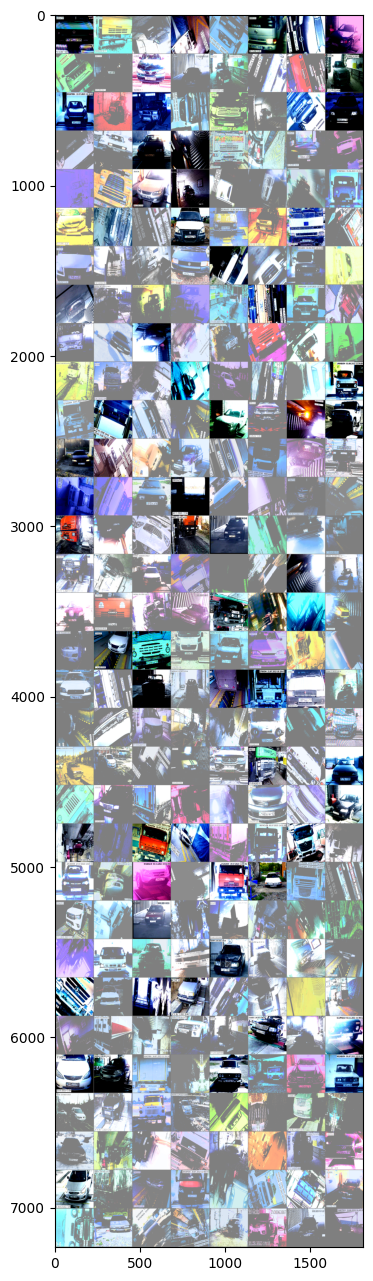

fictiv fictiv fictiv correct fictiv correct fictiv correct fictiv correct fictiv correct correct fictiv fictiv correct fictiv correct correct fictiv fictiv correct fictiv correct fictiv correct correct correct fictiv correct fictiv fictiv correct fictiv correct correct fictiv correct correct fictiv fictiv correct correct fictiv correct correct fictiv correct fictiv correct correct fictiv correct fictiv fictiv fictiv correct correct correct correct correct fictiv fictiv correct correct fictiv correct correct correct fictiv fictiv correct correct correct correct correct correct correct correct fictiv fictiv fictiv fictiv correct correct fictiv correct correct correct correct correct correct fictiv fictiv correct fictiv correct correct correct fictiv correct correct correct correct correct correct fictiv correct correct correct correct correct correct correct correct correct correct correct correct correct correct fictiv correct correct correct fictiv correct correct correct correct ficti

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)


images, labels = next(dataiter)  # Use 'next()' instead of 'dataiter.next()'

f = plt.figure(figsize=(16, 16))

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
# Load the pre-trained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in resnet_model.parameters():
    param.requires_grad = False

# Modifying the final fully connected layer to match the number of classes in custom dataset
num_classes = 2  # number of classess
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001) # check the learning rate

In [ ]:

for epoch in range(30):
    print(epoch)
    resnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

resnet_model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = running_test_loss / len(testloader)
avg_test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
# Freeze all layers except the final fully connected layer
for param in resnet_model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001) # check the learning rate orig/10

In [ ]:
# Training loop
for epoch in range(30):
    resnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

In [ ]:
# Set the model to evaluation mode
resnet_model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = running_test_loss / len(testloader)
avg_test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")

In [ ]:
torch.save(resnet_model.state_dict(), 'model_weights.pth')

In [ ]:
# When we laod the model, we can uncomment it and run this

# resnet_model = models.resnet18()
# num_classes = 2  # Use the number of classes from your custom dataset
# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
# resnet_model.load_state_dict(torch.load('model_weights.pth', map_location=torch.device('cpu')))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# resnet_model.to(device)
# print(device)
# resnet_model.eval()

cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
data_dir = '/content/drive/MyDrive/datasaur/test_test'

# for inferencing
inf_image_paths = [] #to store image paths in list
classes = [] #to store class values


for data_path in glob.glob(data_dir + '/*'):

    inf_image_paths.append(glob.glob(data_path + '/*'))

inf_image_paths = list(flatten(inf_image_paths))
#random.shuffle(train_image_paths)

print('train_image_path example: ', inf_image_paths[0])
#print('class example: ', classes[0])


class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

IndexError: ignored

In [ ]:
# get the names of the file
import csv
ile_names = []
with open("/content/drive/MyDrive/datasaur/test.csv", 'r') as file:
  csvreader = csv.reader(file)
  for row in csvreader:
    file_names.append(row[0])

file_names = file_names[1:]
print(file_names)

In [ ]:
i = 1
with open('students.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     writer.writerow(["file_index", "class"])
     for image_filepath  in file_names:
        print(i)
        name_image = image_filepath
        image_filepath = "/content/drive/MyDrive/datasaur/test/" + image_filepath + '.jpeg'
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # label = image_filepath.split('/')[-2]
        # label = class_to_idx[label]
        if test_transforms is not None:
            image = test_transforms(image=image)["image"]
            image = image.to(device)
            image = image.reshape((1,3,224,224))
            outputs = resnet_model(image)
            _, predicted = torch.max(outputs.data, 1)
            writer.writerow([name_image, int(predicted[0])])
            print(predicted)
            print(image_filepath)
        i +=1
